# Timesfm Usage Example

## Loading Timesfm Model

In [1]:
# External imports
import os
import sys
import numpy as np

src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(sys.path)

# Local imports
from samay.model import TimesfmModel
from samay.dataset import TimesfmDataset

# Load the pretrained model
repo = "google/timesfm-1.0-200m-pytorch"
config = {
    "context_len": 512,
    "horizon_len": 192,
    "backend": "gpu",
    "per_core_batch_size": 32,
    "input_patch_len": 32,
    "output_patch_len": 128,
    "num_layers": 20,
    "model_dims": 1280,
    "quantiles": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}

tfm = TimesfmModel(config=config, repo=repo)

['/nethome/sanand315/anaconda3/lib/python312.zip', '/nethome/sanand315/anaconda3/lib/python3.12', '/nethome/sanand315/anaconda3/lib/python3.12/lib-dynload', '', '/nethome/sanand315/Samay/.venv/lib/python3.12/site-packages', '/nethome/sanand315/Samay/src']


/nethome/sanand315/Samay/.venv/lib/python3.12/site-packages/einops/einops.py:827: SyntaxWarning: invalid escape sequence '\s'
  """


Using device: cuda:0


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.58k [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/814M [00:00<?, ?B/s]

## Define the datasets

In [2]:
train_dataset = TimesfmDataset(
    name="ett",
    datetime_col="date",
    path="../src/samay/models/moment/data/ETTh1.csv",
    mode="train",
    context_len=config["context_len"],
    horizon_len=128,
)
val_dataset = TimesfmDataset(
    name="ett",
    datetime_col="date",
    path="../src/samay/models/moment/data/ETTh1.csv",
    mode="test",
    context_len=config["context_len"],
    horizon_len=config["horizon_len"],
)

In [3]:
[x for x in dir(train_dataset) if "__" not in x]

['batchsize',
 'boundaries',
 'context_len',
 'data',
 'data_path',
 'dataset',
 'datetime_col',
 'freq',
 'get_data_loader',
 'horizon_len',
 'mode',
 'name',
 'normalize',
 'num_ts',
 'preprocess',
 'preprocess_eval_batch',
 'preprocess_train_batch',
 'save',
 'stride',
 'ts_cols']

`data` is of `pd.DataFrame` type and `dataset` is of `CustomTorchDataset` type

In [5]:
len(train_dataset.dataset), len(val_dataset.dataset)

(982, 18)

## Evaluate the zero-shot forecasting

In [6]:
avg_loss, trues, preds, histories = tfm.evaluate(val_dataset)
print("Validation loss:", avg_loss)

Validation loss: 0.5428836594025294


## Visualization of the evaluation
The following code visualises the forecast for a randomly picked `channel` and a randomly picked `time_index`

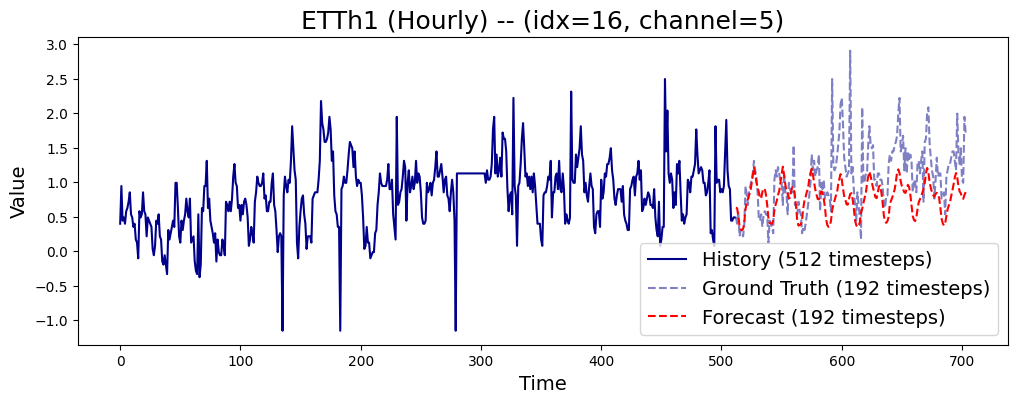

In [7]:
import matplotlib.pyplot as plt

# Pick a random channel and time index
trues = np.array(trues)
preds = np.array(preds)
histories = np.array(histories)
channel_idx = np.random.randint(0, 7)
time_index = np.random.randint(0, trues.shape[0])

history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label="History (512 timesteps)", c="darkblue")

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(
    range(offset, offset + len(true)),
    true,
    label="Ground Truth (192 timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + len(pred)),
    pred,
    label="Forecast (192 timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Finetune Timesfm Model on the ETT dataset

In [8]:
finetuned_model = tfm.finetune(train_dataset)

Epoch 0, Loss: 3.5382650590712026
Epoch 1, Loss: 3.3453146307327
Epoch 2, Loss: 3.1762870301621215
Epoch 3, Loss: 3.094895987340547
Epoch 4, Loss: 2.996309186640426
Epoch 5, Loss: 2.9527580876764277
Epoch 6, Loss: 2.887030963198499
Epoch 7, Loss: 2.8150718693466623
Epoch 8, Loss: 2.7688652477029376
Epoch 9, Loss: 2.737860681871835


## Test the Finetuned Model

In [9]:
avg_loss, trues, preds, histories = tfm.evaluate(val_dataset)
print("Validation loss:", avg_loss)

Validation loss: 0.515854402548737


## Visualization of the evaluation
The following code visualises the forecast for a randomly picked `channel` and a randomly picked `time_index`

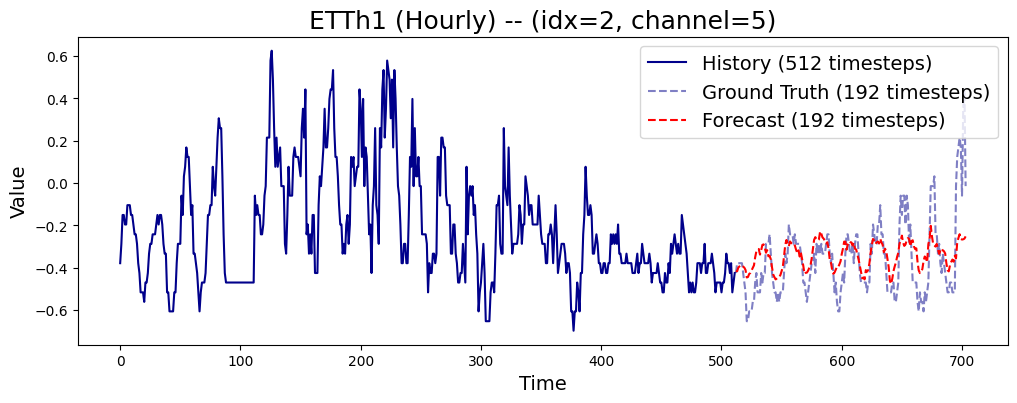

In [10]:
import matplotlib.pyplot as plt

# Pick a random channel and time index
trues = np.array(trues)
preds = np.array(preds)
histories = np.array(histories)
channel_idx = np.random.randint(0, 7)
time_index = np.random.randint(0, trues.shape[0])

history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label="History (512 timesteps)", c="darkblue")

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(
    range(offset, offset + len(true)),
    true,
    label="Ground Truth (192 timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + len(pred)),
    pred,
    label="Forecast (192 timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()